## IMPORTS

In [84]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LinearRegression
%matplotlib inline
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV


from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


In [85]:
features=pd.read_csv('/Users/deepak/Downloads/indeed_data_science_exercise 2/train_features_2013-03-07.csv')
salaries=pd.read_csv('/Users/deepak/Downloads/indeed_data_science_exercise 2/train_salaries_2013-03-07.csv')
all_data=features.join(salaries,lsuffix='_')

##  Initial Exploration of data and EDA

In [3]:
print("SHAPE: ",features.shape)
print("SIZE:",features.size)

SHAPE:  (1000000, 8)
SIZE: 8000000


In [4]:
(features.head())

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
features.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [6]:
print(features.describe())

       yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         11.992386            49.529260
std           7.212391            28.877733
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max          24.000000            99.000000


## Is there Skew in the  Continuous Parameters?

In [7]:
#skewness and kurtosis
print("Skewness: %f" % (salaries["salary"].skew()))
print("Kurtosis: %f" % (salaries["salary"].kurt()))

Skewness: 0.346415
Kurtosis: -0.025579


In [8]:
print(features.skew())

# Values close to 0 show less skew

yearsExperience        0.001674
milesFromMetropolis   -0.001139
dtype: float64


## Salary Distribution


count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

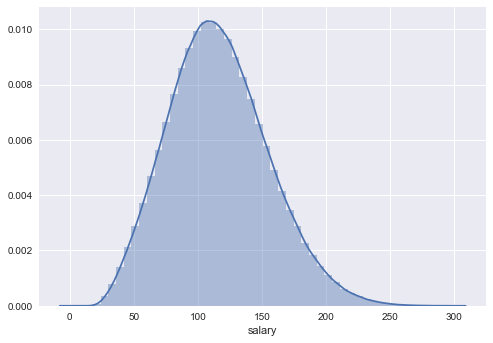

In [9]:
sns.distplot((salaries["salary"]))
all_data.salary.describe()


Salary is normally distributed no need for transformations.

#### Seperate Continuous and categorical Features

In [10]:
contFeatureslist = []
for colName,x in features.iloc[1,:].iteritems():
    if(not str(x).isalpha()):
        contFeatureslist.append(colName)
contFeatureslist

['jobId', 'companyId', 'degree', 'yearsExperience', 'milesFromMetropolis']

In [11]:
catFeatureslist = []
for colName,x in features.iloc[1,:].iteritems():
    if(str(x).isalpha()):
        catFeatureslist.append(colName)
catFeatureslist

['jobType', 'major', 'industry']

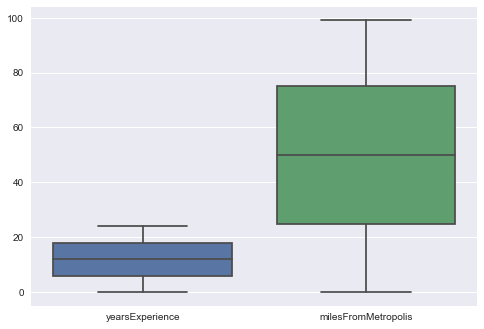

In [12]:
sns.boxplot(features[contFeatureslist])

Skew is really small can be Ignored

In [13]:
## Empty Values

all_data.isnull().sum()  ## No Empty Values

jobId_                 0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
jobId                  0
salary                 0
dtype: int64

## Relationship with categorical features




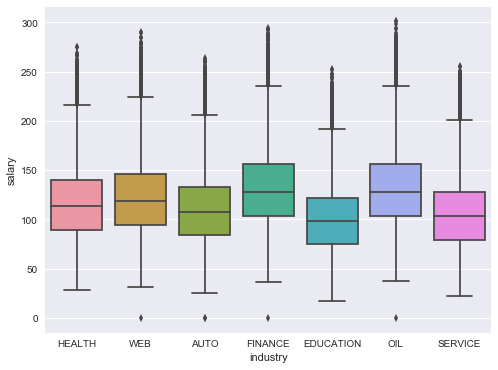

In [14]:
#box plot industry/salary
var = 'industry'
data = pd.concat([all_data['salary'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="salary", data=all_data)
#fig.axis(ymin=0, ymax=800000);

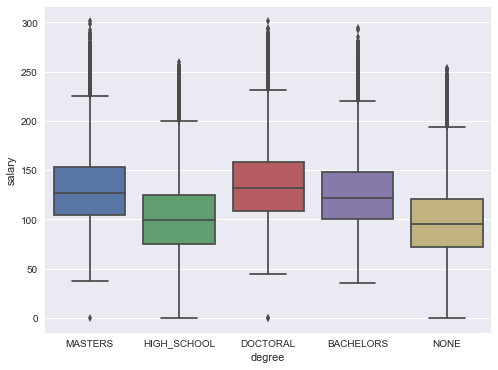

In [15]:
#box plot degree/salary
var = 'degree'
data = pd.concat([all_data['salary'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="salary", data=all_data)
#fig.axis(ymin=0, ymax=800000);

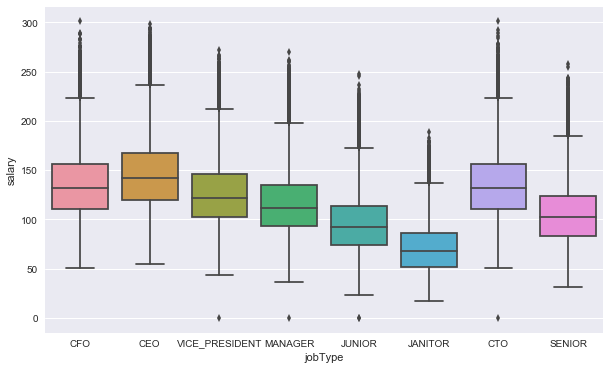

In [16]:
#box plot jobType/salary
var = 'jobType'
data = pd.concat([all_data['salary'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="salary", data=all_data)
#fig.axis(ymin=0, ymax=800000);

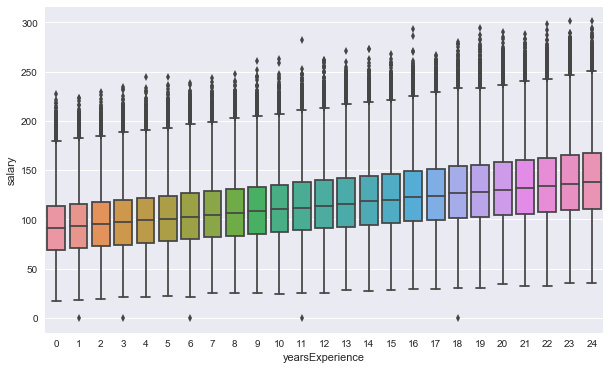

In [17]:
#box plot yearsExperience/salary
var = 'yearsExperience'
data = pd.concat([all_data['salary'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="salary", data=all_data)

## GROUP SALARY BY DEGREE

In [18]:
salary_by_degree=all_data.groupby("degree").salary.agg(['count', 'mean', 'min', 'max'])
salary_by_degree

,count,mean,min,max
degree,,,,
BACHELORS,175495,125.454663,35,294
DOCTORAL,175364,135.489433,0,301
HIGH_SCHOOL,236976,101.920654,0,260
MASTERS,175311,130.504903,0,301
NONE,236854,98.176467,0,254


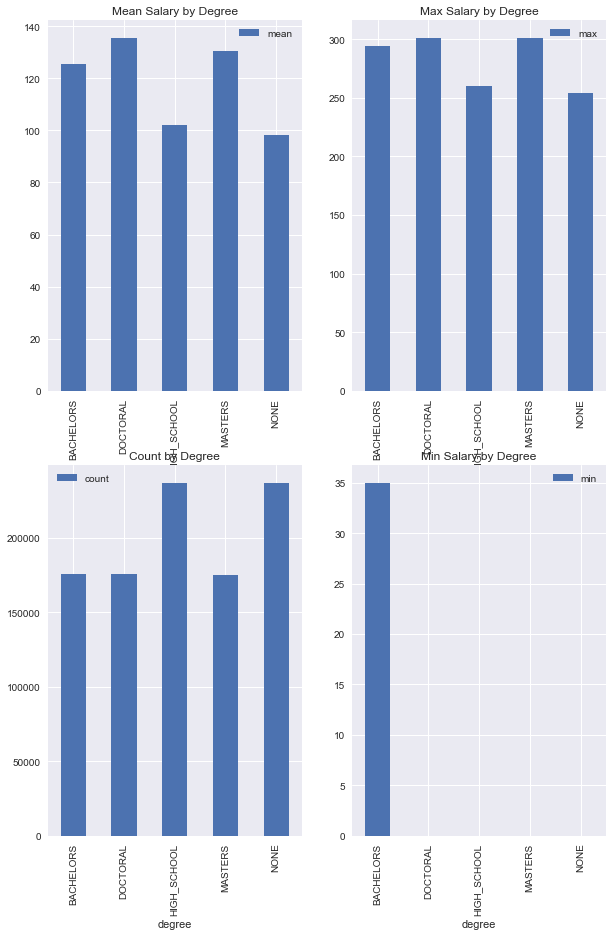

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
salary_by_degree.plot(y='mean',kind="bar",title="Mean Salary by Degree",ax=axes[0,0],figsize=(10,15))
salary_by_degree.plot(y='max',kind="bar",title="Max Salary by Degree",ax=axes[0,1])
salary_by_degree.plot(y='count',kind="bar",title="Count by Degree",ax=axes[1,0])
salary_by_degree.plot(y='min',kind="bar",title="Min Salary by Degree",ax=axes[1,1])

plt.show()

## Observations:

* As Expected mean Salary has the following order- 
Doctoral > Masters > Bachelors > None


* Minimum Salary doesnt make sense bacaause of '0' Salary in some cases

## GROUP SALARY BY INDUSTRY

In [20]:
salary_by_industry=all_data.groupby("industry").salary.agg(['count', 'mean', 'min', 'max'])
salary_by_industry

,count,mean,min,max
industry,,,,
AUTO,142943,109.433690,0,264
EDUCATION,142819,99.448386,17,253
FINANCE,142867,130.746743,0,294
HEALTH,142755,115.735540,28,275
OIL,142771,130.952946,0,301
SERVICE,142639,104.446820,22,256
WEB,143206,121.644512,0,290


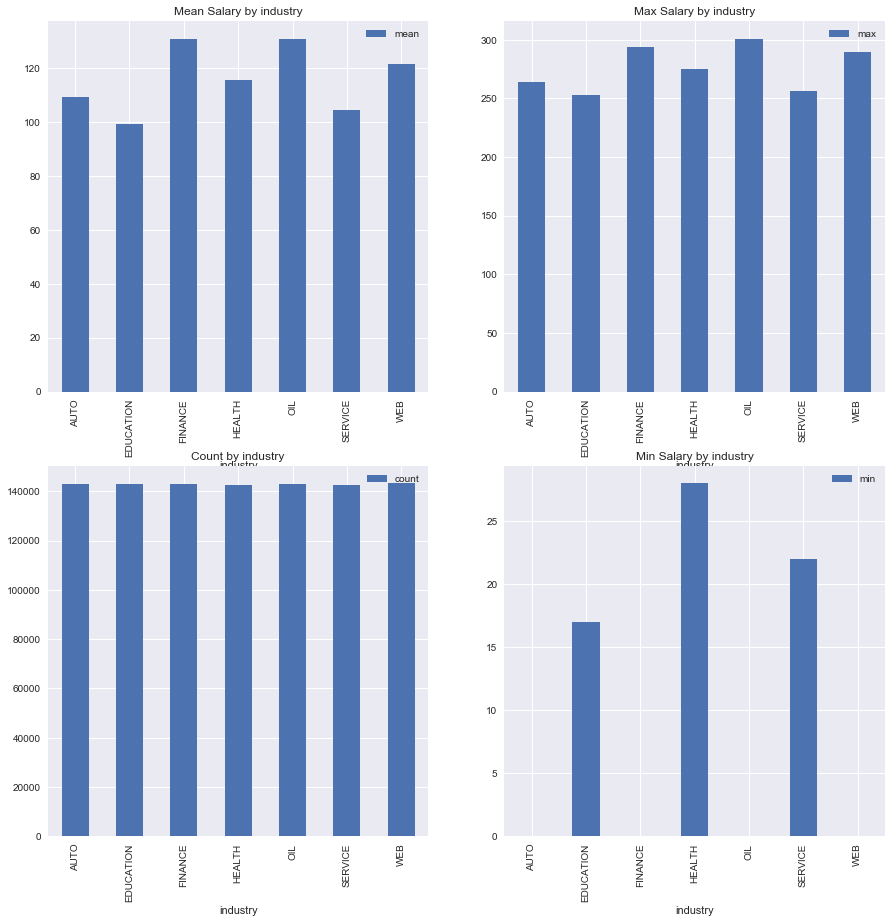

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2)
salary_by_industry.plot(y='mean',kind="bar",title="Mean Salary by industry",ax=axes[0,0],figsize=(15,15))
salary_by_industry.plot(y='max',kind="bar",title="Max Salary by industry",ax=axes[0,1])
salary_by_industry.plot(y='count',kind="bar",title="Count by industry",ax=axes[1,0])
salary_by_industry.plot(y='min',kind="bar",title="Min Salary by industry",ax=axes[1,1])

plt.show()

## GROUP SALARY BY JOBTYPE

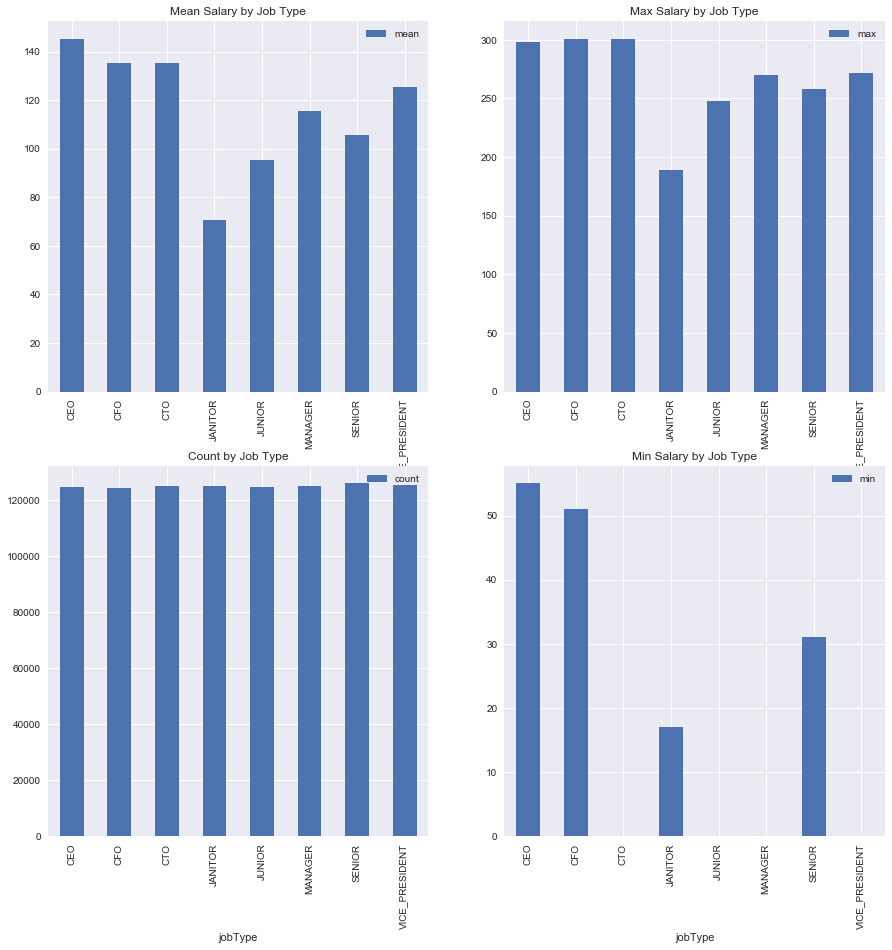

In [22]:
salary_by_jobType=all_data.groupby("jobType").salary.agg(['count', 'mean', 'min', 'max'])
salary_by_jobType
fig, axes = plt.subplots(nrows=2, ncols=2)
salary_by_jobType.plot(y='mean',kind="bar",title="Mean Salary by Job Type",ax=axes[0,0],figsize=(15,15))
salary_by_jobType.plot(y='max',kind="bar",title="Max Salary by Job Type",ax=axes[0,1])
salary_by_jobType.plot(y='count',kind="bar",title="Count by Job Type",ax=axes[1,0])
salary_by_jobType.plot(y='min',kind="bar",title="Min Salary by Job Type",ax=axes[1,1])

plt.show()

In [23]:
salary_by_jobType

,count,mean,min,max
jobType,,,,
CEO,124778,145.311425,55,298
CFO,124369,135.458547,51,301
CTO,125046,135.479983,0,301
JANITOR,124971,70.813045,17,189
JUNIOR,124594,95.331557,0,248
MANAGER,125121,115.367596,0,270
SENIOR,125886,105.487775,31,258
VICE_PRESIDENT,125235,125.367629,0,272


## OBSERVATIONS
* Average SALARY is maximum for CEO and minimum for Janitor(almost half of CEO )
* Almost Equal number of Observations for each Job type

## GROUP SALARY BY YEARS OF EXPERIENCE

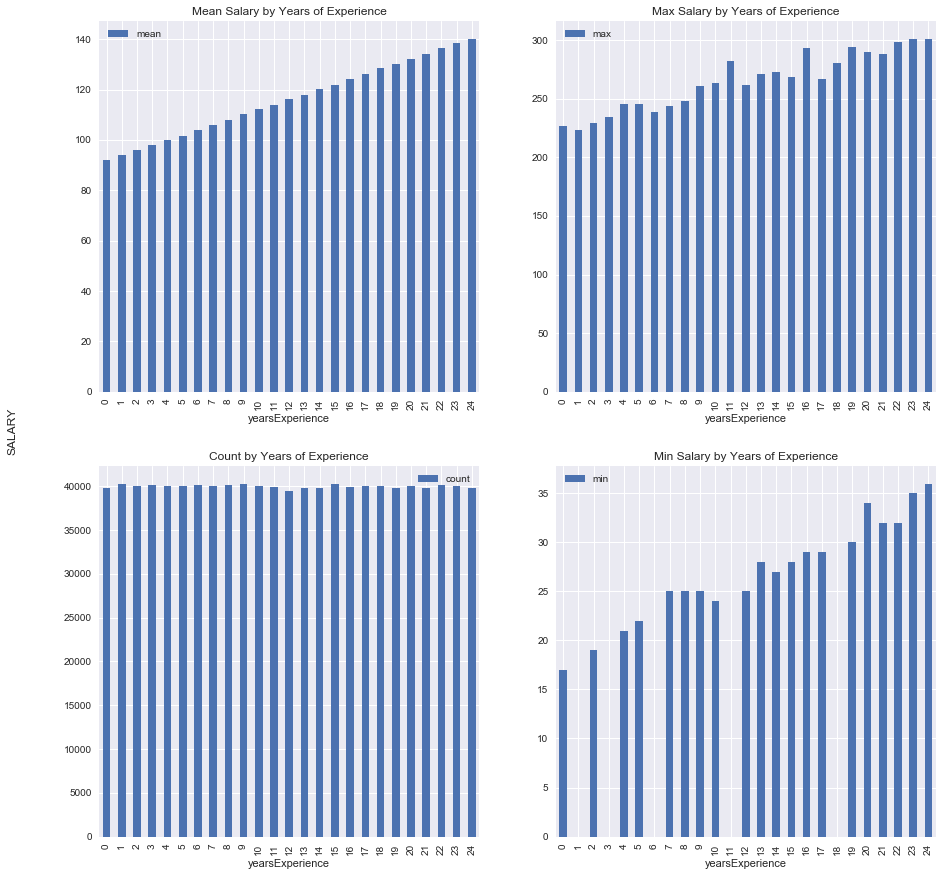

In [24]:
value=all_data.groupby("yearsExperience").salary.agg(['count', 'mean', 'min', 'max'])
value
fig, axes = plt.subplots(nrows=2, ncols=2)
value.plot(y='mean',kind="bar",title="Mean Salary by Years of Experience",ax=axes[0,0],figsize=(15,15))
value.plot(y='max',kind="bar",title="Max Salary by Years of Experience",ax=axes[0,1])
value.plot(y='count',kind="bar",title="Count by Years of Experience",ax=axes[1,0])
value.plot(y='min',kind="bar",title="Min Salary by Years of Experience",ax=axes[1,1])
fig.text(0.04,0.5, 'SALARY', va='center', rotation='vertical')

plt.show()

In [25]:
value[0:5]

,count,mean,min,max
yearsExperience,,,,
0,39839,91.873541,17,227
1,40265,93.960040,0,223
2,40045,96.125184,19,229
3,40191,98.090368,0,234
4,40036,100.014112,21,245


## OBSERVATIONS

* We see a clear linear trend in increase of mean salary with years of expereince

## GROUP SALARY BY YEARS OF miles from Metroplois

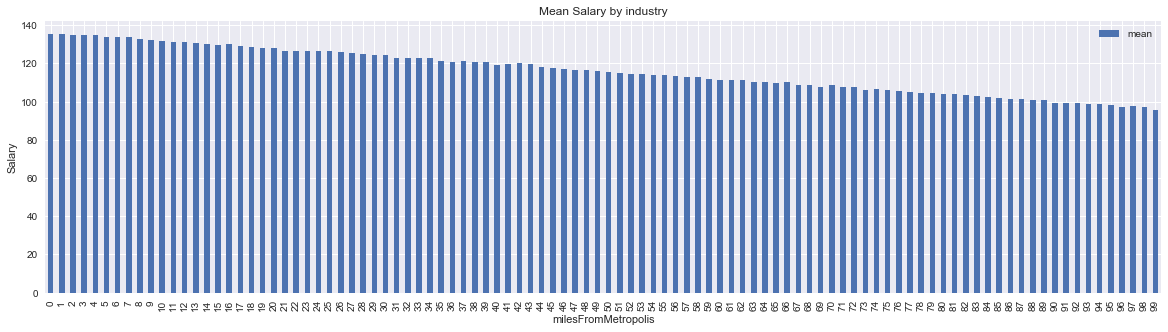

In [26]:
value=all_data.groupby("milesFromMetropolis").salary.agg(['count', 'mean', 'min', 'max'])
value
value.plot(y='mean',kind="bar",title="Mean Salary by industry",figsize=(20,5))
plt.ylabel('Salary')
# value.plot(y='max',kind="bar",title="Max Salary by industry",ax=axes[0,1])
# value.plot(y='count',kind="bar",title="Count by industry",ax=axes[1,0])
# value.plot(y='min',kind="bar",title="Min Salary by industry",ax=axes[1,1])

# plt.show()

## OBSERVATION

* There is a clear trend that as distance from metropolis increases salary decreases

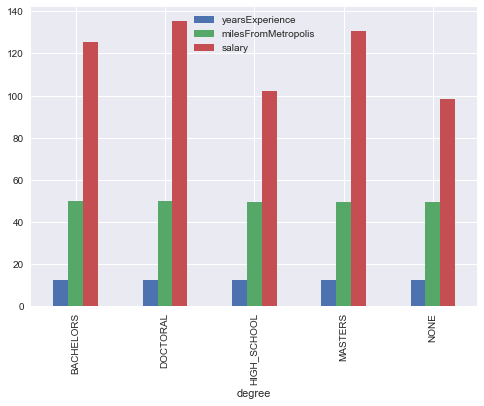

In [27]:
#x=all_data.drop(["yearsExperience"],axis=1)
all_data.groupby("degree").mean().plot(kind="bar")

In [28]:
all_data.head()

,jobId_,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,jobId,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,JOB1362684407687,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,JOB1362684407688,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,JOB1362684407689,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,JOB1362684407690,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,JOB1362684407691,163


## Normalized count by Categorical Variables

In [29]:
print("degree-Normalized Count: \n",all_data.degree.value_counts(normalize=True),"\n")
print("industry-Normalized Count: \n",all_data.industry.value_counts(normalize=True),"\n")
print("jobType-Normalized Count: \n",all_data.jobType.value_counts(normalize=True),"\n")

degree-Normalized Count: 
 HIGH_SCHOOL    0.236976
NONE           0.236854
BACHELORS      0.175495
DOCTORAL       0.175364
MASTERS        0.175311
Name: degree, dtype: float64 

industry-Normalized Count: 
 WEB          0.143206
AUTO         0.142943
FINANCE      0.142867
EDUCATION    0.142819
OIL          0.142771
HEALTH       0.142755
SERVICE      0.142639
Name: industry, dtype: float64 

jobType-Normalized Count: 
 SENIOR            0.125886
VICE_PRESIDENT    0.125235
MANAGER           0.125121
CTO               0.125046
JANITOR           0.124971
CEO               0.124778
JUNIOR            0.124594
CFO               0.124369
Name: jobType, dtype: float64 



There seems to be a uniform distrbution of examples between different categorical values

## What Industry are most educated and least educated people working in?

industry         AUTO  EDUCATION   FINANCE    HEALTH       OIL   SERVICE  \
degree                                                                     
BACHELORS    0.025212   0.025143  0.025065  0.025002  0.024922  0.025064   
DOCTORAL     0.025231   0.025060  0.025085  0.025105  0.025187  0.024699   
HIGH_SCHOOL  0.033581   0.034058  0.033769  0.033867  0.033959  0.033634   
MASTERS      0.025006   0.024814  0.025088  0.025123  0.024975  0.025080   
NONE         0.033913   0.033744  0.033860  0.033658  0.033728  0.034162   

industry          WEB  
degree                 
BACHELORS    0.025087  
DOCTORAL     0.024997  
HIGH_SCHOOL  0.034108  
MASTERS      0.025225  
NONE         0.033789  


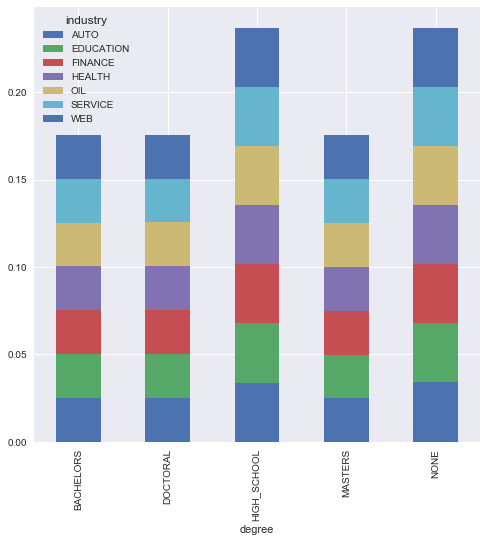

In [30]:
table=pd.crosstab(all_data.degree, all_data.industry, normalize=True)
print(table)
table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

Most educated and least educated people are uniformly spread across all industries

In [31]:
table

industry,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE,WEB
degree,,,,,,,
BACHELORS,0.025212,0.025143,0.025065,0.025002,0.024922,0.025064,0.025087
DOCTORAL,0.025231,0.025060,0.025085,0.025105,0.025187,0.024699,0.024997
HIGH_SCHOOL,0.033581,0.034058,0.033769,0.033867,0.033959,0.033634,0.034108
MASTERS,0.025006,0.024814,0.025088,0.025123,0.024975,0.025080,0.025225
NONE,0.033913,0.033744,0.033860,0.033658,0.033728,0.034162,0.033789


jobType           CEO       CFO       CTO   JANITOR    JUNIOR   MANAGER  \
degree                                                                    
BACHELORS    0.025123  0.024983  0.025057  0.000000  0.024872  0.025018   
DOCTORAL     0.025145  0.024697  0.024920  0.000000  0.025021  0.024968   
HIGH_SCHOOL  0.024721  0.024912  0.024894  0.062427  0.025080  0.024895   
MASTERS      0.024891  0.025063  0.025293  0.000000  0.024839  0.025148   
NONE         0.024898  0.024714  0.024882  0.062544  0.024782  0.025092   

jobType        SENIOR  VICE_PRESIDENT  
degree                                 
BACHELORS    0.025318        0.025124  
DOCTORAL     0.025379        0.025234  
HIGH_SCHOOL  0.024846        0.025201  
MASTERS      0.025226        0.024851  
NONE         0.025117        0.024825  


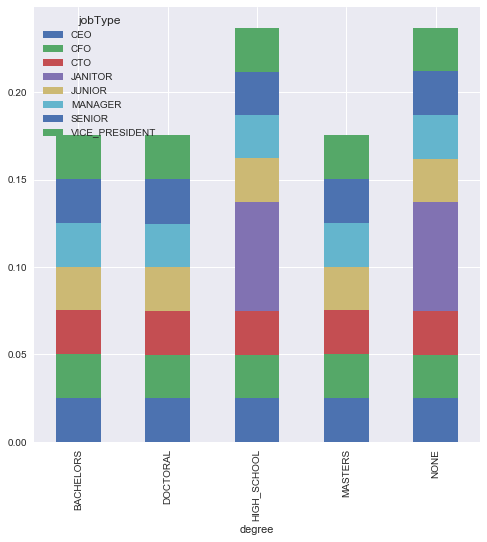

In [32]:
table=pd.crosstab(all_data.degree, all_data.jobType, normalize=True)
print(table)
table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

* High school degree holders as likely to become CEO's  as PhD holders
* All Janitors have high school or 'NONE' degree

In [33]:
features.companyId.unique()

array(['COMP37', 'COMP19', 'COMP52', 'COMP38', 'COMP7', 'COMP15', 'COMP24',
       'COMP20', 'COMP41', 'COMP56', 'COMP4', 'COMP54', 'COMP57', 'COMP14',
       'COMP61', 'COMP58', 'COMP3', 'COMP44', 'COMP30', 'COMP27', 'COMP34',
       'COMP11', 'COMP31', 'COMP49', 'COMP0', 'COMP1', 'COMP36', 'COMP47',
       'COMP8', 'COMP42', 'COMP50', 'COMP53', 'COMP48', 'COMP45', 'COMP46',
       'COMP2', 'COMP5', 'COMP55', 'COMP29', 'COMP40', 'COMP33', 'COMP22',
       'COMP12', 'COMP25', 'COMP6', 'COMP23', 'COMP17', 'COMP28', 'COMP21',
       'COMP26', 'COMP43', 'COMP51', 'COMP10', 'COMP59', 'COMP13',
       'COMP39', 'COMP16', 'COMP9', 'COMP32', 'COMP62', 'COMP35', 'COMP18',
       'COMP60'], dtype=object)

## Univariate analysis



The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [34]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(all_data['salary'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-2.99762557]
 [-2.99762557]
 [-2.99762557]
 [-2.99762557]
 [-2.99762557]
 [-2.55855236]
 [-2.53272453]
 [-2.53272453]
 [-2.53272453]
 [-2.50689669]]

outer range (high) of the distribution:
[[ 4.49244679]
 [ 4.54410246]
 [ 4.54410246]
 [ 4.5699303 ]
 [ 4.5699303 ]
 [ 4.59575813]
 [ 4.59575813]
 [ 4.69906947]
 [ 4.77655298]
 [ 4.77655298]]


- Low range values are similar and not too far from 0. All values are under 3 standard deviations
- High range values are far. There are about 10 values outside 4 standard deviations.


## Testing for the assumptions for multivariate analysis

* Nornality
* Homoscedasticity
* Linearity
* Absence of correlated errors


No or little multicollinearity There is no perfect linear relationship between explanatory variables. Multicollinearity occurs when the independent variables are not independent from each other.

Correlation matrix – when computing the matrix of Pearson's Bivariate Correlation among all independent variables the correlation coefficients need to be smaller than 1.
VIF is a metric computed for every X variable that goes into a linear model. If the VIF of a variable is high, it means the information in that variable is already explained by other X variables present in the given model, which means, more redundant is that variable. So, lower the VIF (<2) the better
Normality of residuals

The mean of residuals is zero

No auto-correlation (Autocorrelation occurs when the residuals are not independent from each other. In other words when the value of y(x+1) is not independent from the value of y(x).) It is observed in time series data.

Homoscedasticity of residuals or equal variance


https://github.com/dualphase90/ML-Notes/blob/master/docs/Supervised_learning.md

## normality

Histogram - Kurtosis and skewness.

Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

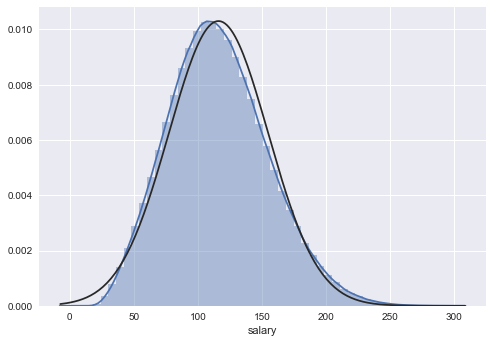

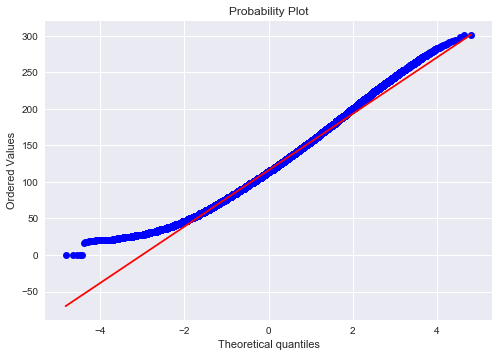

In [35]:
#histogram and normal probability plot
from scipy import stats
sns.distplot(all_data['salary'], fit=norm);
fig = plt.figure()
res = stats.probplot(all_data['salary'], plot=plt)

* Salary has passed the test.

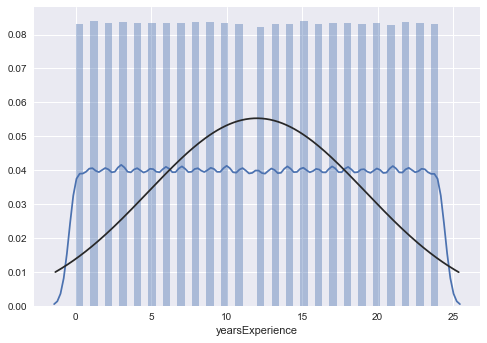

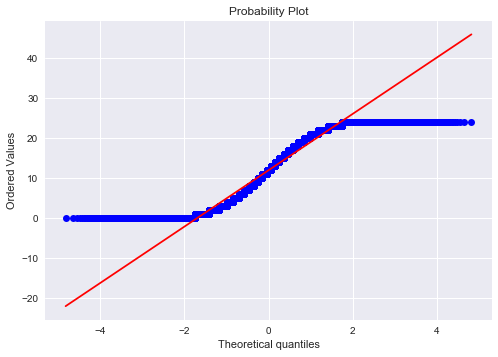

In [36]:
#histogram and normal probability plot
from scipy import stats
sns.distplot(all_data['yearsExperience'], fit=norm);
fig = plt.figure()
res = stats.probplot(all_data['yearsExperience'], plot=plt)


* yearsExperience are uniformly distributed.
* milesFromMetropolis are uniformly distributed.

The normality assumption for linear regression applies to the errors, not the outcome variable per se (and most certainly not to the explanatory variables).  The usual statement is that the errors are i.i.d. (i.e., independently and identically distributed) as Normal with a mean of 0 and some variance.  Independence and homoscedasticity are more important assumptions than normality.


## What Combination of 2 variables gives highest Salary?

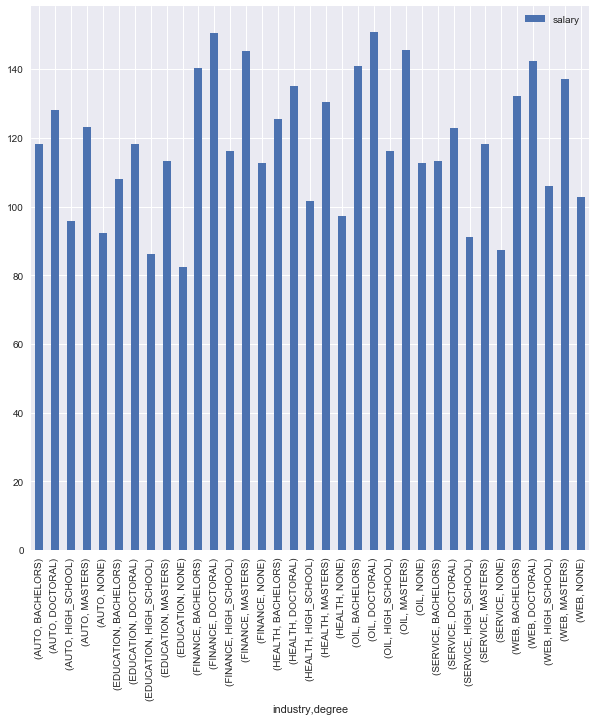

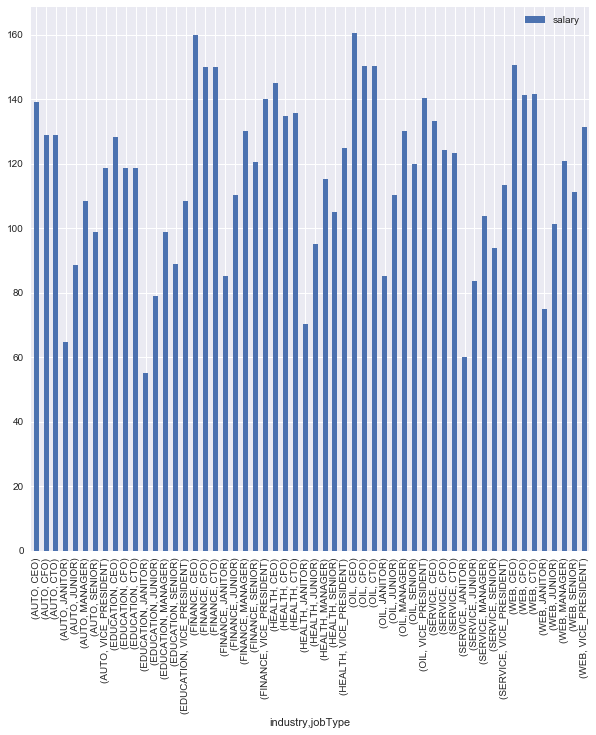

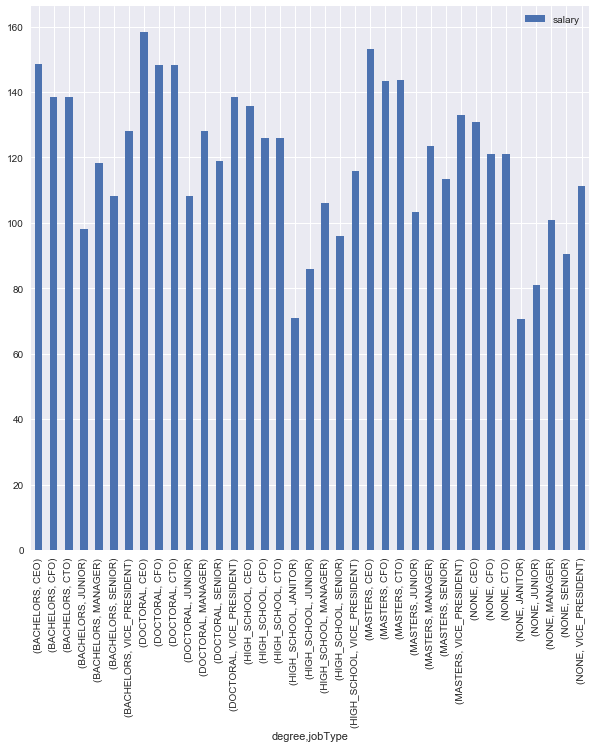

In [115]:
all_data.groupby(['industry', 'degree']).mean()[['salary']].plot(kind="bar",figsize=(10,10))
all_data.groupby(['industry', 'jobType']).mean()[['salary']].plot(kind="bar",figsize=(10,10))
all_data.groupby(['degree', 'jobType']).mean()[['salary']].plot(kind="bar",figsize=(10,10))

## PREPARE DATA FOR TRAINING

In [42]:
train_data=features.drop(["jobId","companyId"],axis=1)
objects = list(train_data.select_dtypes(include=['object']).columns)
objects

['jobType', 'degree', 'major', 'industry']

In [43]:
from sklearn.feature_extraction import DictVectorizer

def one_hot_dataframe(data, cols, replace=False):
    vec = DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform(data[cols].apply(mkdict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace is True:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData, vec)


In [44]:
train_data, _, _ = one_hot_dataframe(train_data,objects, replace=True)
print (train_data.head(2))

   yearsExperience  milesFromMetropolis  degree=BACHELORS  degree=DOCTORAL  \
0               10                   83               0.0              0.0   
1                3                   73               0.0              0.0   

   degree=HIGH_SCHOOL  degree=MASTERS  degree=NONE  industry=AUTO  \
0                 0.0             1.0          0.0            0.0   
1                 1.0             0.0          0.0            0.0   

   industry=EDUCATION  industry=FINANCE      ...        \
0                 0.0               0.0      ...         
1                 0.0               0.0      ...         

   jobType=VICE_PRESIDENT  major=BIOLOGY  major=BUSINESS  major=CHEMISTRY  \
0                     0.0            0.0             0.0              0.0   
1                     0.0            0.0             0.0              0.0   

   major=COMPSCI  major=ENGINEERING  major=LITERATURE  major=MATH  major=NONE  \
0            0.0                0.0               0.0         1.0    

In [49]:
train_data.head()

,yearsExperience,milesFromMetropolis,degree=BACHELORS,degree=DOCTORAL,degree=HIGH_SCHOOL,degree=MASTERS,degree=NONE,industry=AUTO,industry=EDUCATION,industry=FINANCE,...,jobType=VICE_PRESIDENT,major=BIOLOGY,major=BUSINESS,major=CHEMISTRY,major=COMPSCI,major=ENGINEERING,major=LITERATURE,major=MATH,major=NONE,major=PHYSICS
0,10,83,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,73,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10,38,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8,17,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
## CORRELATION WITH SALARY

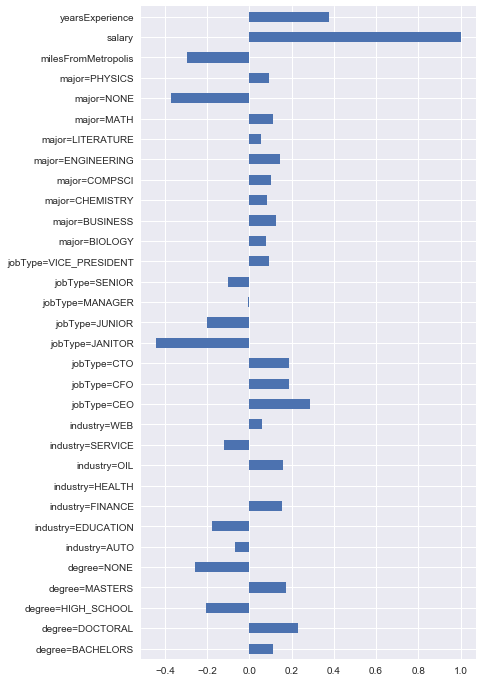

In [53]:
all_data=train_data.join(salaries,lsuffix='_')
all_data=all_data.append(train_data)
all_data=all_data.append(salaries)
#corr = all_data.corr()
(corr.salary.plot(kind="barh",figsize=(6,12)))

In [55]:
print("TOP 5 negative Correlation with Salary:")
print(corr.salary.sort_values()[0:5],"\n")

print("TOP 5 positive Correlation with Salary:")
print(corr.salary.sort_values()[-6:])

TOP 5 negative Correlation with Salary:
jobType=JANITOR       -0.441660
major=NONE            -0.371421
milesFromMetropolis   -0.297666
degree=NONE           -0.257349
degree=HIGH_SCHOOL    -0.203543
Name: salary, dtype: float64 

TOP 5 positive Correlation with Salary:
jobType=CFO        0.188804
jobType=CTO        0.189600
degree=DOCTORAL    0.231391
jobType=CEO        0.285245
yearsExperience    0.375013
salary             1.000000
Name: salary, dtype: float64


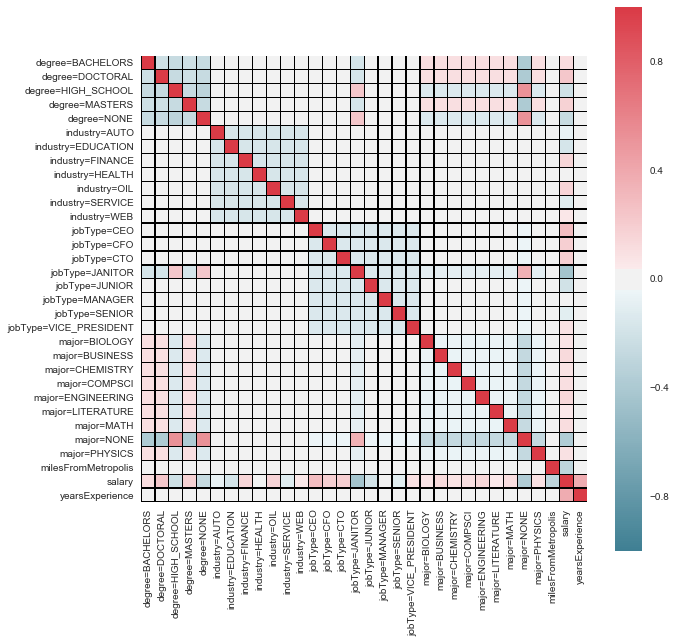

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(all_data.corr(),linewidths=0.25,vmax=1.0,cmap=cmap,square=True, linecolor='black')
sns.plt.show()


## REMOVE ROWS WITH EMPTY SALARIES

In [198]:
sum(salaries["salary"]==0)

5

In [203]:
salaries[salaries["salary"]==0]["jobId"]

30559     JOB1362684438246
495984    JOB1362684903671
652076    JOB1362685059763
816129    JOB1362685223816
828156    JOB1362685235843
Name: jobId, dtype: object

## SPLIT DATA FOR CROSS-VALIDATION

In [57]:
train_data.head()

,yearsExperience,milesFromMetropolis,degree=BACHELORS,degree=DOCTORAL,degree=HIGH_SCHOOL,degree=MASTERS,degree=NONE,industry=AUTO,industry=EDUCATION,industry=FINANCE,...,jobType=VICE_PRESIDENT,major=BIOLOGY,major=BUSINESS,major=CHEMISTRY,major=COMPSCI,major=ENGINEERING,major=LITERATURE,major=MATH,major=NONE,major=PHYSICS
0,10,83,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,73,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10,38,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8,17,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [127]:
from sklearn.cross_validation import train_test_split
#all_data=all_data.drop(["salary"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_data, salaries["salary"], random_state=1)

In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Model 1 : Linear Regression

In [59]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
# print the intercept and coefficients
print("INTERCERPT",linreg.intercept_)
print("COEFFICENTS",linreg.coef_[0:5])

INTERCERPT -807604955367.0
COEFFICENTS [  2.00923570e+00  -4.00000917e-01  -1.30901008e+11  -1.30901008e+11
  -1.30901008e+11]


INTERCEPT  is equal to the mean Salary.

### pair the feature names with the coefficients

In [61]:
list(zip(train_data.columns, linreg.coef_))[0:5]

[('yearsExperience', 2.0092356977155705),
 ('milesFromMetropolis', -0.40000091746839483),
 ('degree=BACHELORS', -130901008463.24237),
 ('degree=DOCTORAL', -130901008453.23749),
 ('degree=HIGH_SCHOOL', -130901008468.99805)]

### Model Performance

In [150]:
y_pred = linreg.predict(X_test)
print(r2_score(y_pred,y_test, multioutput='variance_weighted'))
from sklearn.metrics import mean_squared_error
linreg_score = rmse_cv(linreg)
print(linreg_score)
linreg_score=np.mean(linreg_score)

0.656237137466
[ 19.61495166  19.64625844  19.62058097  19.63047513  19.56342906]


## RIDGE

In [86]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

19.615143592309934

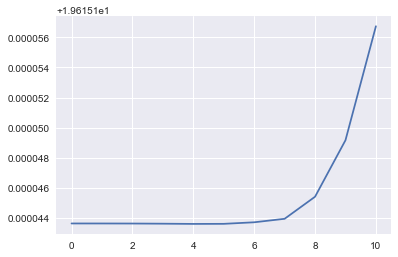

In [93]:
plt.plot(cv_ridge)
min(cv_ridge)

## LASSO

In [95]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
lasso_score=rmse_cv(model_lasso).mean()
print(lasso_score)

19.615145199001226

In [ ]:
## plot coefficents

Lasso picked 31 variables and eliminated the other 0 variables


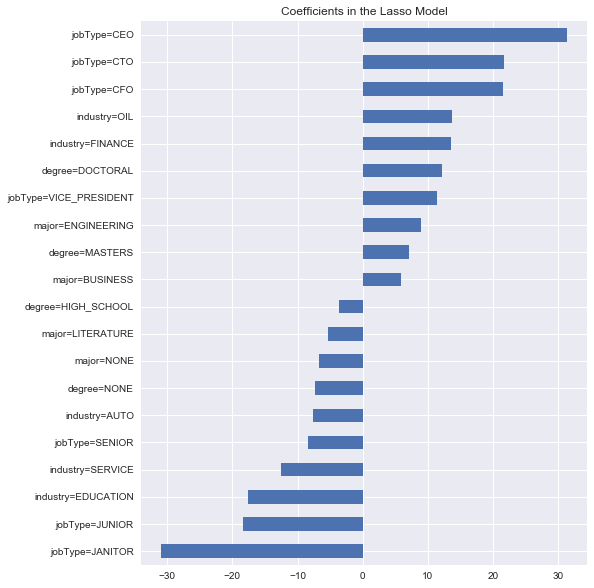

In [99]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)


imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## XGBOOST

In [102]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

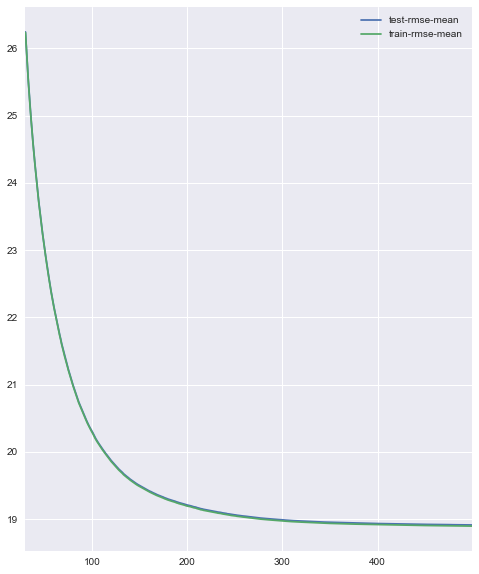

In [103]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


In [105]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [107]:
xgb_score=rmse_cv(model_xgb)
print(xgb_scoore)
xgb_score=np.mean(xgb_score)

array([ 18.94927627,  18.9869047 ,  18.9318483 ,  18.96474104,  18.89925948])

## KERAS NN

In [110]:
train_data = StandardScaler().fit_transform(train_data)
X_tr, X_val, y_tr, y_val = train_test_split(train_data, salaries["salary"], random_state = 3)
model = Sequential()
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))
model.compile(loss = "mse", optimizer = "adam")

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [112]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 750000 samples, validate on 250000 samples
Epoch 1/10
750000/750000 [==============================] - 43s - loss: 11711.4694 - val_loss: 9074.4630
Epoch 2/10
750000/750000 [==============================] - 44s - loss: 7060.3264 - val_loss: 5243.3410
Epoch 3/10
750000/750000 [==============================] - 41s - loss: 3818.2778 - val_loss: 2562.7869
Epoch 4/10
750000/750000 [==============================] - 43s - loss: 1676.6990 - val_loss: 959.8098
Epoch 5/10
750000/750000 [==============================] - 43s - loss: 598.2214 - val_loss: 395.9025
Epoch 6/10
750000/750000 [==============================] - 43s - loss: 386.2127 - val_loss: 383.7916
Epoch 7/10
750000/750000 [==============================] - 43s - loss: 384.9259 - val_loss: 383.8353
Epoch 8/10
750000/750000 [==============================] - 40s - loss: 384.9243 - val_loss: 383.9179
Epoch 9/10
750000/750000 [==============================] - 42s - loss: 384.9224 - val_loss: 383.8060
Epoch 10/10
750000/750

In [134]:
dnn_score= np.sqrt(hist.history['val_loss'][-1])
dnn_score

19.59269260930251

In [128]:
from sklearn.ensemble import RandomForestRegressor
seed=0
random_clf = RandomForestRegressor(n_jobs=-1,n_estimators=30,random_state=seed)
rf_score=rmse_cv(random_clf)
print(rf_score)
rf_score=np.mean(rf_score)

array([ 21.10634183,  21.18002871,  21.11787322,  21.12444541,  21.0653401 ])

In [145]:
rf_score=np.mean(rf_score)

In [166]:
scores={"rf_score":rf_score,
"dnn_score":dnn_score,
"xgb_score":xgb_score,
"lasso_score":lasso_score}

In [167]:
plt.bar(scores)

TypeError: bar() missing 1 required positional argument: 'height'

In [96]:
model_ridge = Ridge()
#alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
alpha=[0.0001,0.001]
cv_ridges=( [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas])


In [110]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
rmse_cv(model_lasso)

array([ 19.61491405,  19.64621182,  19.62057187,  19.63058548,  19.56344278])

## READ TEST DATA AND PREDICT

In [175]:
test=pd.read_csv("/Users/deepak/Downloads/indeed_data_science_exercise/test_features_2013-03-07.csv")
test, _, _ = one_hot_dataframe(test,objects, replace=True)
test=test.drop(["jobId","companyID"],axis=1)
test.head()


In [195]:
sal=model_lasso.predict(test)

In [196]:
test2=pd.read_csv("/Users/deepak/Downloads/indeed/indeed_data_science_exercise_2/test_set_with_predictions.csv")

In [197]:
mean_squared_error(sal,test2["predictions"])

1.5966988976493661

In [191]:
test2.head()

,Unnamed: 0,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,predictions
0,0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,115.566596
1,1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,92.071743
2,2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,165.043784
3,3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,105.897531
4,4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,118.497997
